# CSC 673 Assignment 2:
##### Author: Md Asifur Rahman
#### Acknowledgements: 
1. Brazil Stock Market dataset is taken from https://www.kaggle.com/datasets/leomauro/brazilian-stock-market-data-warehouse
2. 14 clean energy data is extracted using Yfinance

# Package Installation

In [ ]:
!pip install mlxtend
!pip install tqdm
!pip install yfinance
!pip install pandas-datareader

In [ ]:
import pandas as pd
import numpy as np
import warnings
import os
import file_processor as fp 
from tqdm import tqdm
import stock_data_processor
import association_rule_mining
import predictor
import plotly.express as px
from sklearn.metrics import r2_score
import pickle
from IPython.display import display
import matplotlib.pyplot as plt
import re
warnings.filterwarnings('ignore')

# 1. Minimal Performance

### 1.1 Aggregating Brazilian Stock data

In [44]:
data_path_comp_info = '../data/dimCompany.csv'
dataset_comp_info = pd.read_csv(data_path_comp_info)
data_path_trans_date_info = '../data/dimTime.csv'
dataset_trans_date_info = pd.read_csv(data_path_trans_date_info)
data_coin_info_path = '../data/dimCoin.csv'
dataset_coin_info = pd.read_csv(data_coin_info_path)
data_path_currency_info_path = '../data/factCoins.csv'
dataset_currency_info = pd.read_csv(data_path_currency_info_path)
data_stock_value_info_info_path = '../data/factStocks.csv'
dataset_stock_value_info = pd.read_csv(data_stock_value_info_info_path)

path_to_file = '../output/brazilian_stock_data_BrReal.csv'

# Use either USD/ EUR to extract data in corresponding currency.
# path_to_file = '../output/brazilian_stock_data_USD.csv'
# path_to_file = '../output/brazilian_stock_data_EUR.csv'
if not os.path.exists(path_to_file):
    df = stock_data_processor.transoform_stock_data(dataset_stock_value_info, 
                                                    dataset_comp_info, 
                                                    dataset_trans_date_info, 
                                                    dataset_coin_info, 
                                                    dataset_currency_info,
                                                    conversion=True,
                                                    currency_name = 'EUR'
                                                   )
else:
    df = pd.read_csv(path_to_file, index_col=[0])

In [45]:
df_assocs = df.copy()
df_assocs = df_assocs.sort_values(by=['date'])
df_assocs.head(2)

date stockCodeCompany  open_price  close_price  highest_price  \
1   1998-03-16            ALPA4        45.8         45.8           45.8   
29  1998-03-16            COCE5         4.6          4.5            4.6   

    lowest_price  quantityStock sectorCodeCompany        segmentCompany  
1          45.80          916.0              ICON  SEGMENTS AND SECTORS  
29          4.41       200687.0              IEEX  SEGMENTS AND SECTORS

### 1.2 Extracting Transactions for Association Mining

In [5]:
def condition(df1,df2):
    bool_data = (df1-df2)>=0
    return bool_data

basket_csv_path = '../output/BrReal_aggregated_transaction.csv'
if not os.path.exists(basket_csv_path):
    basket_df_1 = stock_data_processor.get_transaction_basket(df_assocs,
                                                                trans_col='date',
                                                                basket_col='stockCodeCompany', 
                                                                apply_condition= True,
                                                                condition_func=condition,
                                                                condtn_colmn1='close_price', 
                                                                condtn_colmn2='open_price')
    basket_df_1.to_csv(basket_csv_path)
else:
    basket_df_1 = pd.read_csv(basket_csv_path, index_col=[0])

In [6]:
basket_df_1.head(4)

trans_id        date                                             basket
0         0  1998-03-16  ['ALPA4', 'VALE3', 'UNIP6', 'CSNA3', 'RSID3', ...
1         1  1998-03-17  ['ITSA3', 'ITSA4', 'LAME3', 'LAME4', 'PETR4', ...
2         2  1998-03-18  ['ELET6', 'GOAU4', 'ITSA4', 'LAME3', 'RSID3', ...
3         3  1998-03-19  ['ITSA4', 'LAME4', 'PNVL3', 'PETR3', 'UNIP6', ...

### 1.3 Extracting Frequent Itemsets

In [7]:
freq_item_file_name = '../output/brazilian_stockBrReal_frequent_itemset.pkl'
if not os.path.exists(freq_item_file_name):
    freq_item2 = association_rule_mining.get_frequent_itemset(basket_df_1['basket'], min_support=0.25, min_length=3, max_len=11, low_memory=False)
    top_20_frequence = freq_item2.sort_values('support',ascending=False).head(20).sort_values('support')
    fig = px.bar(top_20_frequence, x="support", y="itemsets", orientation='h', text='support')
    fig.show();
    with open(freq_item_file_name, 'wb') as f:
        pickle.dump(freq_item2, f)
else:
    with open(freq_item_file_name, 'rb') as f:
        freq_item2 = pickle.load(f)
    top_20_frequence = freq_item2.sort_values('support',ascending=False).head(20).sort_values('support')
    fig = px.bar(top_20_frequence, 
                 x="support", 
                 y="itemsets", 
                 orientation='h', 
                 text='support', 
                 title="Figure 1: Frequently associated stock companies with closing price higher that opening price")
    fig.show();

### 1.4 What are the best groups of stocks?

#### 1.4.1 Extracting individual company names from the top 20 frequent list of associated companies

In [8]:
clean_item_list = []
i=0
for item in top_20_frequence.itemsets:
    print("# Group ",i+1,"\t:",item)
    i+=1
    item_list = item.split(',')
    for item in item_list:
        clean_item = str(item).strip().split(" ")
        clean_item_list.append(clean_item[0])  
company_names, counts = np.unique(clean_item_list, return_counts=True)
count_sort_ind = np.argsort(-counts)
associated_company_list = company_names[count_sort_ind]

# Group  1 	: PETR4, ITSA4, BBDC4
# Group  2 	: BBDC3, CMIG4, BBDC4
# Group  3 	: ELET6, ELET3, ITSA4
# Group  4 	: GGBR4, GOAU4, GGBR3
# Group  5 	: ELET6, ELET3, CPLE6
# Group  6 	: PETR3, BBAS3, PETR4
# Group  7 	: PETR3, CSNA3, PETR4
# Group  8 	: ELET6, ELET3, CMIG4
# Group  9 	: PETR3, GOAU4, PETR4
# Group  10 	: PETR3, BBDC3, BBDC4
# Group  11 	: VALE3, BRAP4, BRAP3
# Group  12 	: PETR4, BBDC3, BBDC4
# Group  13 	: PETR4, PETR3, BBDC4
# Group  14 	: PETR3, VALE3, PETR4
# Group  15 	: PETR3, BBDC3, PETR4
# Group  16 	: BBAS3, BBDC3, ITSA4
# Group  17 	: PETR3, ITSA4, PETR4
# Group  18 	: BBAS3, ITSA4, BBDC4
# Group  19 	: BBAS3, BBDC3, BBDC4
# Group  20 	: BBDC3, ITSA4, BBDC4


#### Analysis:
Above list indicates the best groups of stocks since the highest price of these stocks tends to goes up most frequently on the same transaction day.

### 1.5 Visualizing trading pattern

#### 1.5.1 Visualizing monthly highest stock price (Brazilian Real) patterns of the companies from the top 20 associated companies

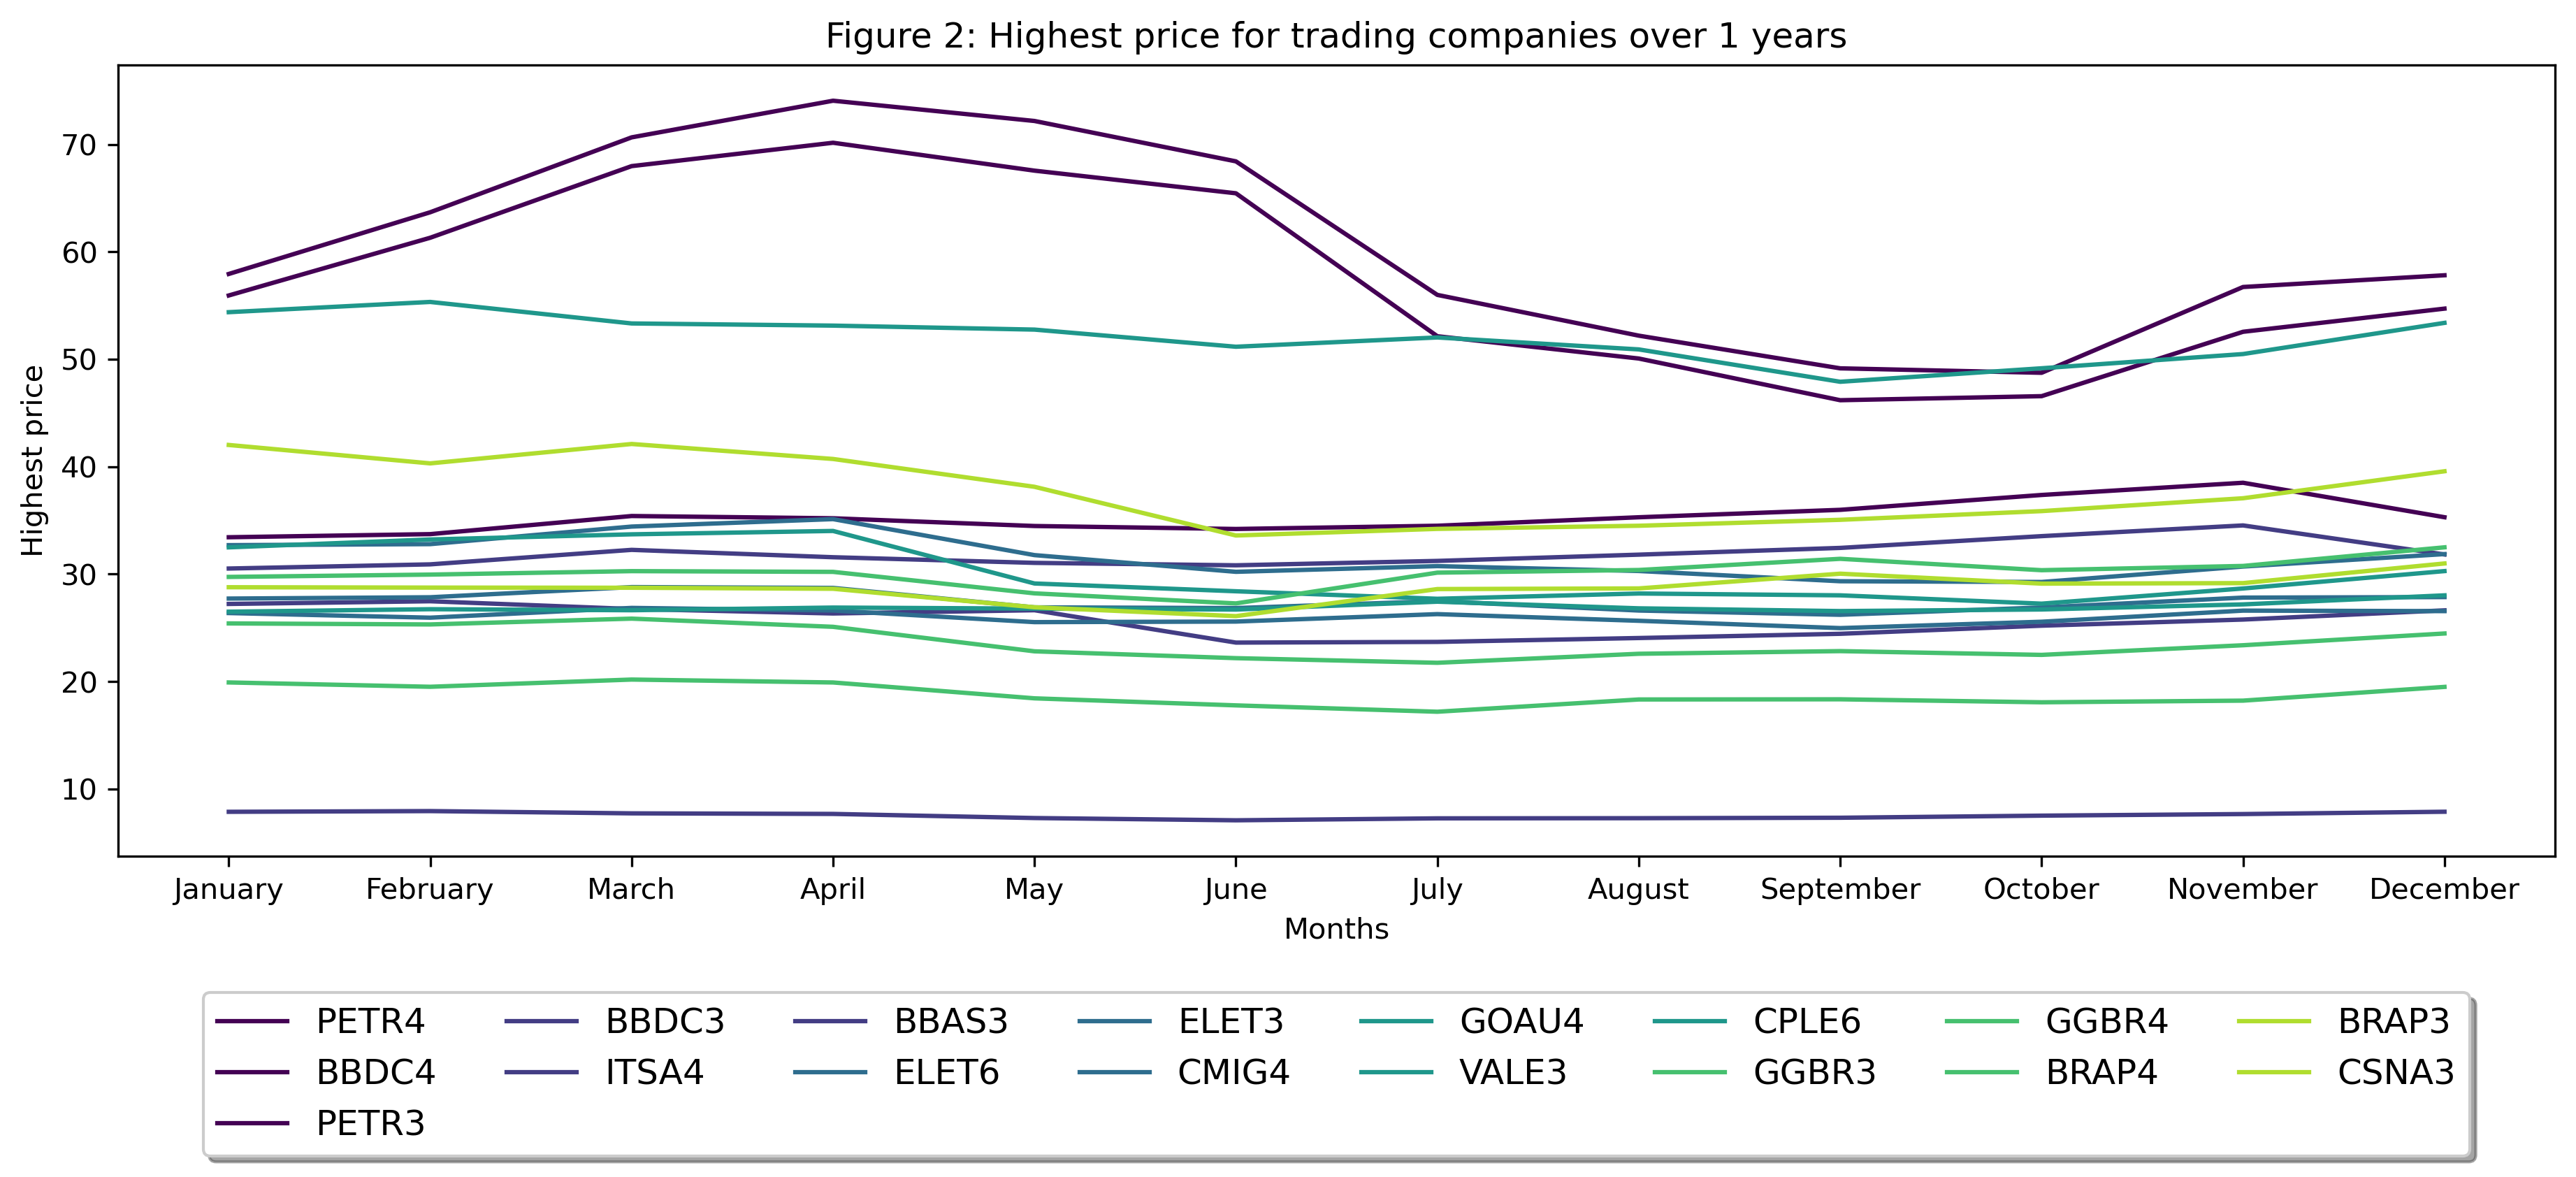

In [9]:
stock_data_sorted = df.sort_values(by=['date'])
df_assoc_group = stock_data_sorted.loc[stock_data_sorted['stockCodeCompany'].isin(associated_company_list)]
stock_data_processor.get_trade_pattern_from_dataframe(df_assoc_group, associated_company_list, category='highest_price', fig_no=2)

#### 1.5.2 Visualizing monthly highest price (Brazilian Real) patterns of the companies from the top 20 associated companies

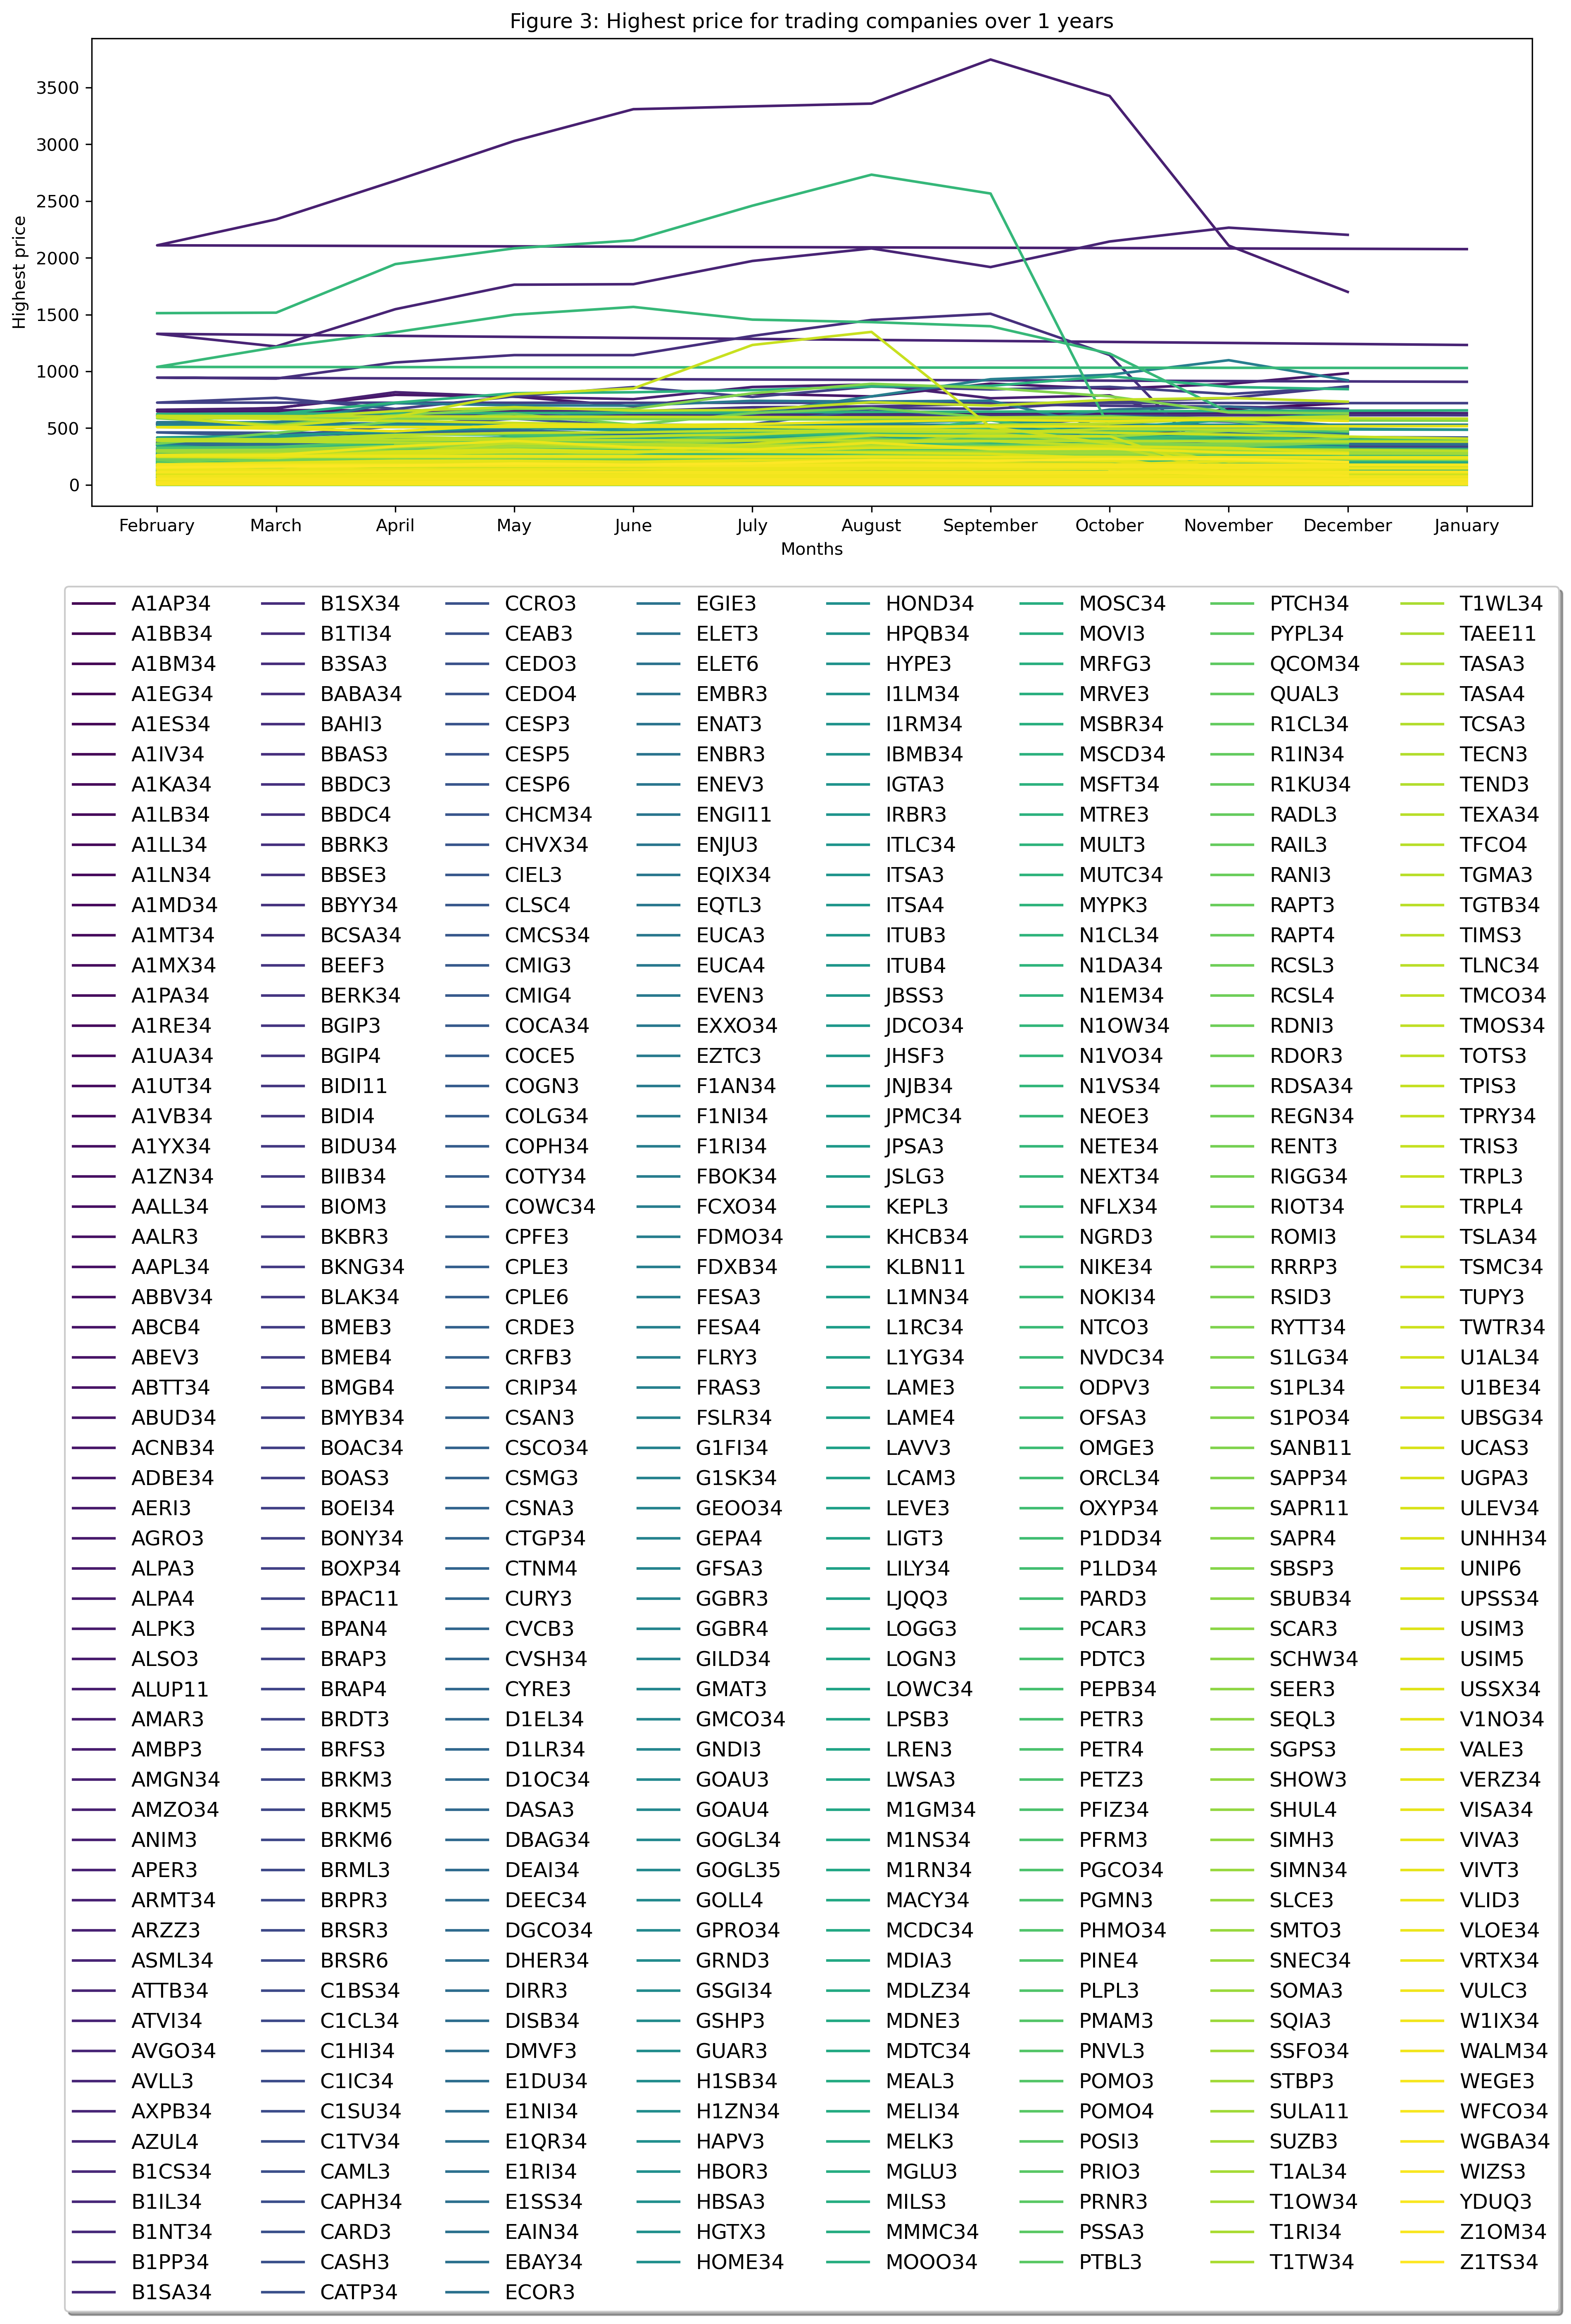

In [10]:
brazilian_stock_company_names, counts = np.unique(stock_data_sorted['stockCodeCompany'], return_counts=True)
stock_data_processor.get_trade_pattern_from_dataframe(stock_data_sorted, brazilian_stock_company_names, category='highest_price',fig_no=3)

# 2. Good Performance

### 2.1 Data Preprocessing

#### 2.1.1 Check redundant data and missing values

In [11]:
print("# No of duplicated rows:", stock_data_sorted.duplicated().sum().sum())
nan_col, nan_row = fp.get_missing_data_info(stock_data_sorted)
print("# No of columns with missing value:",len(nan_col))
print("# No of rows with missing value:",len(nan_row))
 

# No of duplicated rows: 0
# No of columns with missing value: 0
# No of rows with missing value: 0


In [12]:
stock_data_sorted.shape

(680150, 9)

In [13]:
stock_data_sorted.head(2)

date stockCodeCompany  open_price  close_price  highest_price  \
1   1998-03-16            ALPA4        45.8         45.8           45.8   
29  1998-03-16            COCE5         4.6          4.5            4.6   

    lowest_price  quantityStock sectorCodeCompany        segmentCompany  
1          45.80          916.0              ICON  SEGMENTS AND SECTORS  
29          4.41       200687.0              IEEX  SEGMENTS AND SECTORS

#### 2.1.2 Adjusting Feature's Data type

In [14]:
def adjust_feature_types(dataset):
    dataset = dataset.astype(
                  {'date': 'category',
                   'stockCodeCompany': 'category',
                  })
    numeric_columns = dataset.select_dtypes('number').columns
    for column in numeric_columns:
        dataset = dataset.astype({column: 'float64'})
    return dataset

#### 2.1.3 Converting categorical columns to one-hot encoded data

In [15]:
stock_data_feature_adjusted_enc = pd.get_dummies(data=stock_data_sorted, columns=['sectorCodeCompany', 'segmentCompany'])
stock_data_feature_adjusted = adjust_feature_types(stock_data_feature_adjusted_enc)

#### 2.1.4 Pefroming feature selection

In [16]:
feature_selection = fp.remove_features_near_zero_variance(stock_data_feature_adjusted)
selected_cols = feature_selection.columns
stock_data_feature_adjusted_enc = pd.get_dummies(data=stock_data_sorted, columns=['sectorCodeCompany', 'segmentCompany'], sparse=True)
final_stock_data_sorted=stock_data_feature_adjusted_enc[selected_cols]

### 2.2 Evaluating Regression model

In [17]:
x_train, y_train,  = predictor.get_data_for_model(final_stock_data_sorted, target_col='highest_price')

In [21]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

model_path_file = 'model_path.txt'
if not os.path.exists(model_path_file):
    models = [('RandomForest', RandomForestRegressor()),
              ('DecisionTree', DecisionTreeRegressor())]
    s_metrics = 'r2'
    model_save_dir = '../output/prediction_model/'
    best_model = predictor.perform_models_training(models, x_train, y_train, s_metrics, model_save_dir)
else:
    with open('model_path.txt', 'r') as f:
        model_path = f.readlines()
    best_model = predictor.load_model(model_path[0])

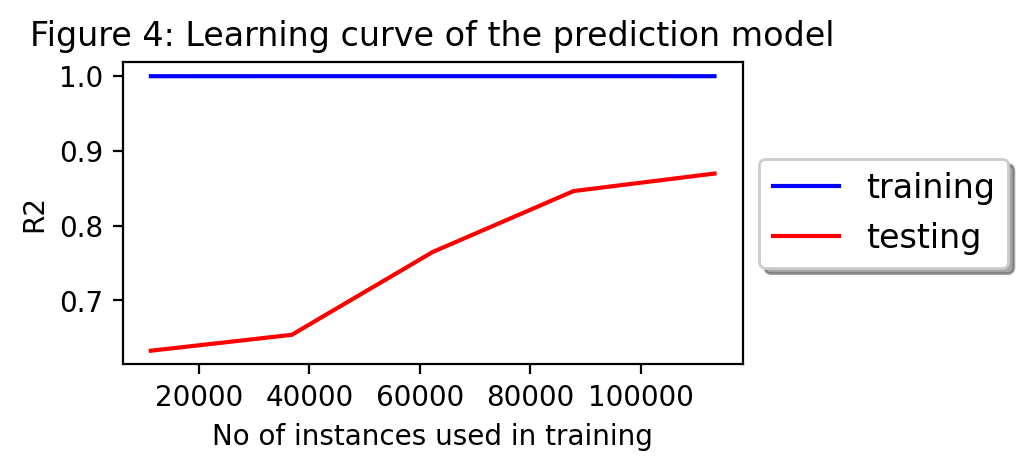

In [22]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import learning_curve
#****************Checking Generalization**********************
tscv = TimeSeriesSplit(n_splits=5)
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(best_model, x_train, y_train, scoring='r2', cv=tscv, return_times=True)
fig = plt.figure(figsize=(4, 2), dpi=200)
plt.plot(train_sizes,np.mean(train_scores,axis=1), color="blue", label="training")
plt.plot(train_sizes,np.mean(test_scores,axis=1), color="red", label="testing")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12, fancybox=True, shadow=True, ncol=1)
plt.xlabel("No of instances used in training")
plt.ylabel("R2")
plt.title("Figure 4: Learning curve of the prediction model")
plt.show()

In [23]:
#************** Perform Prediction ***************************
Y_prediction = best_model.predict(x_train)
r2 = r2_score(y_train, Y_prediction)
adj_r2 = predictor.adjusted_r2(r2,len(Y_prediction), x_train.shape[1])
print("Test result (Adjusted R2) on the whole dataset:", adj_r2)

Test result (Adjusted R2) on the whole dataset: 0.7214819078642789


# 3. Excellent Performance

### 3.1 Visualizing monthly trend of highest price from 14 clear energy stocks

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


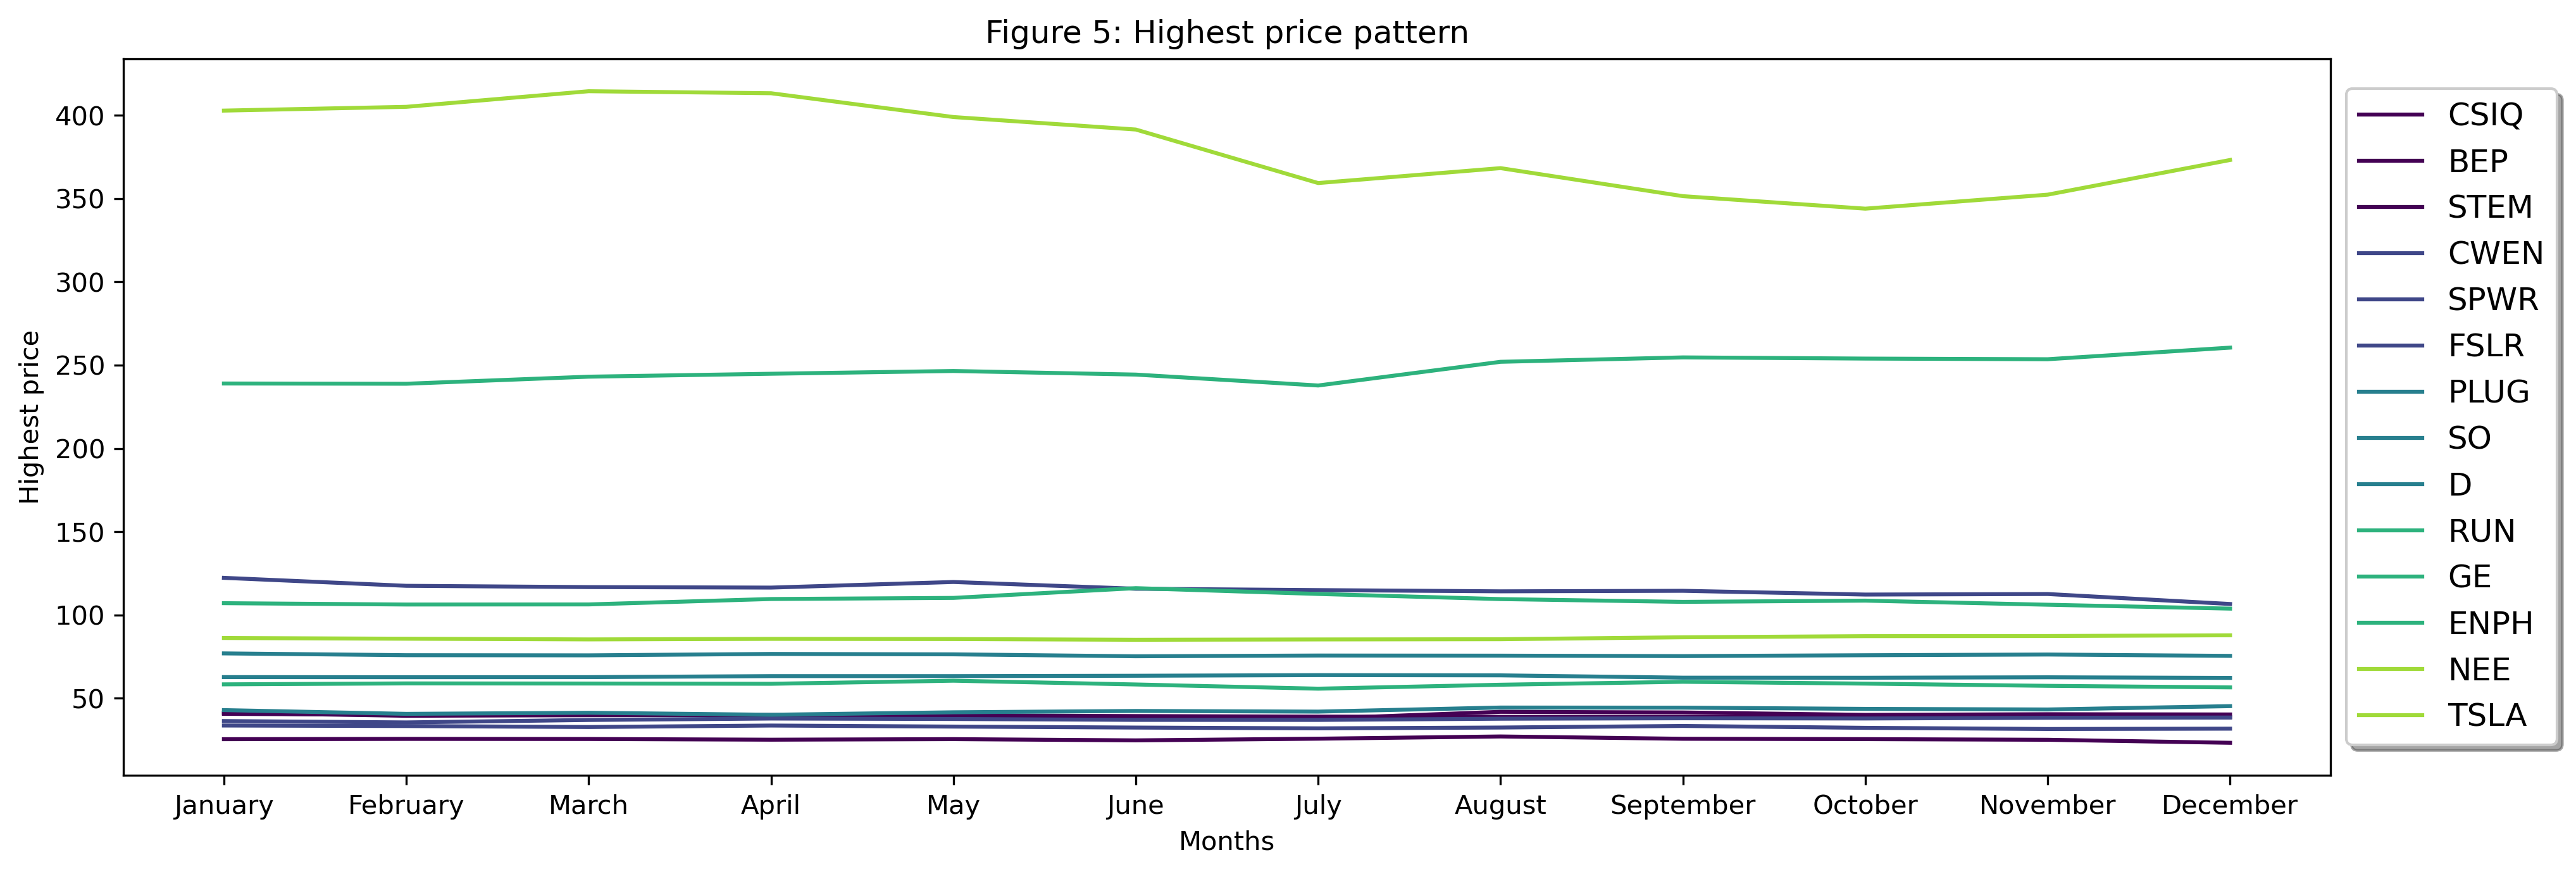

In [24]:
clean_energy_stocks = ['CSIQ','BEP','STEM','CWEN','SPWR','FSLR','PLUG','SO','D','RUN','GE','ENPH','NEE','TSLA']
clean_energy_dataset = stock_data_processor.get_trends(clean_energy_stocks, period='monthly', category='highest_price', fig_no=5)

### 3.2 Visualizing monthly trend of adjusted close price from 14 clear energy stocks

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


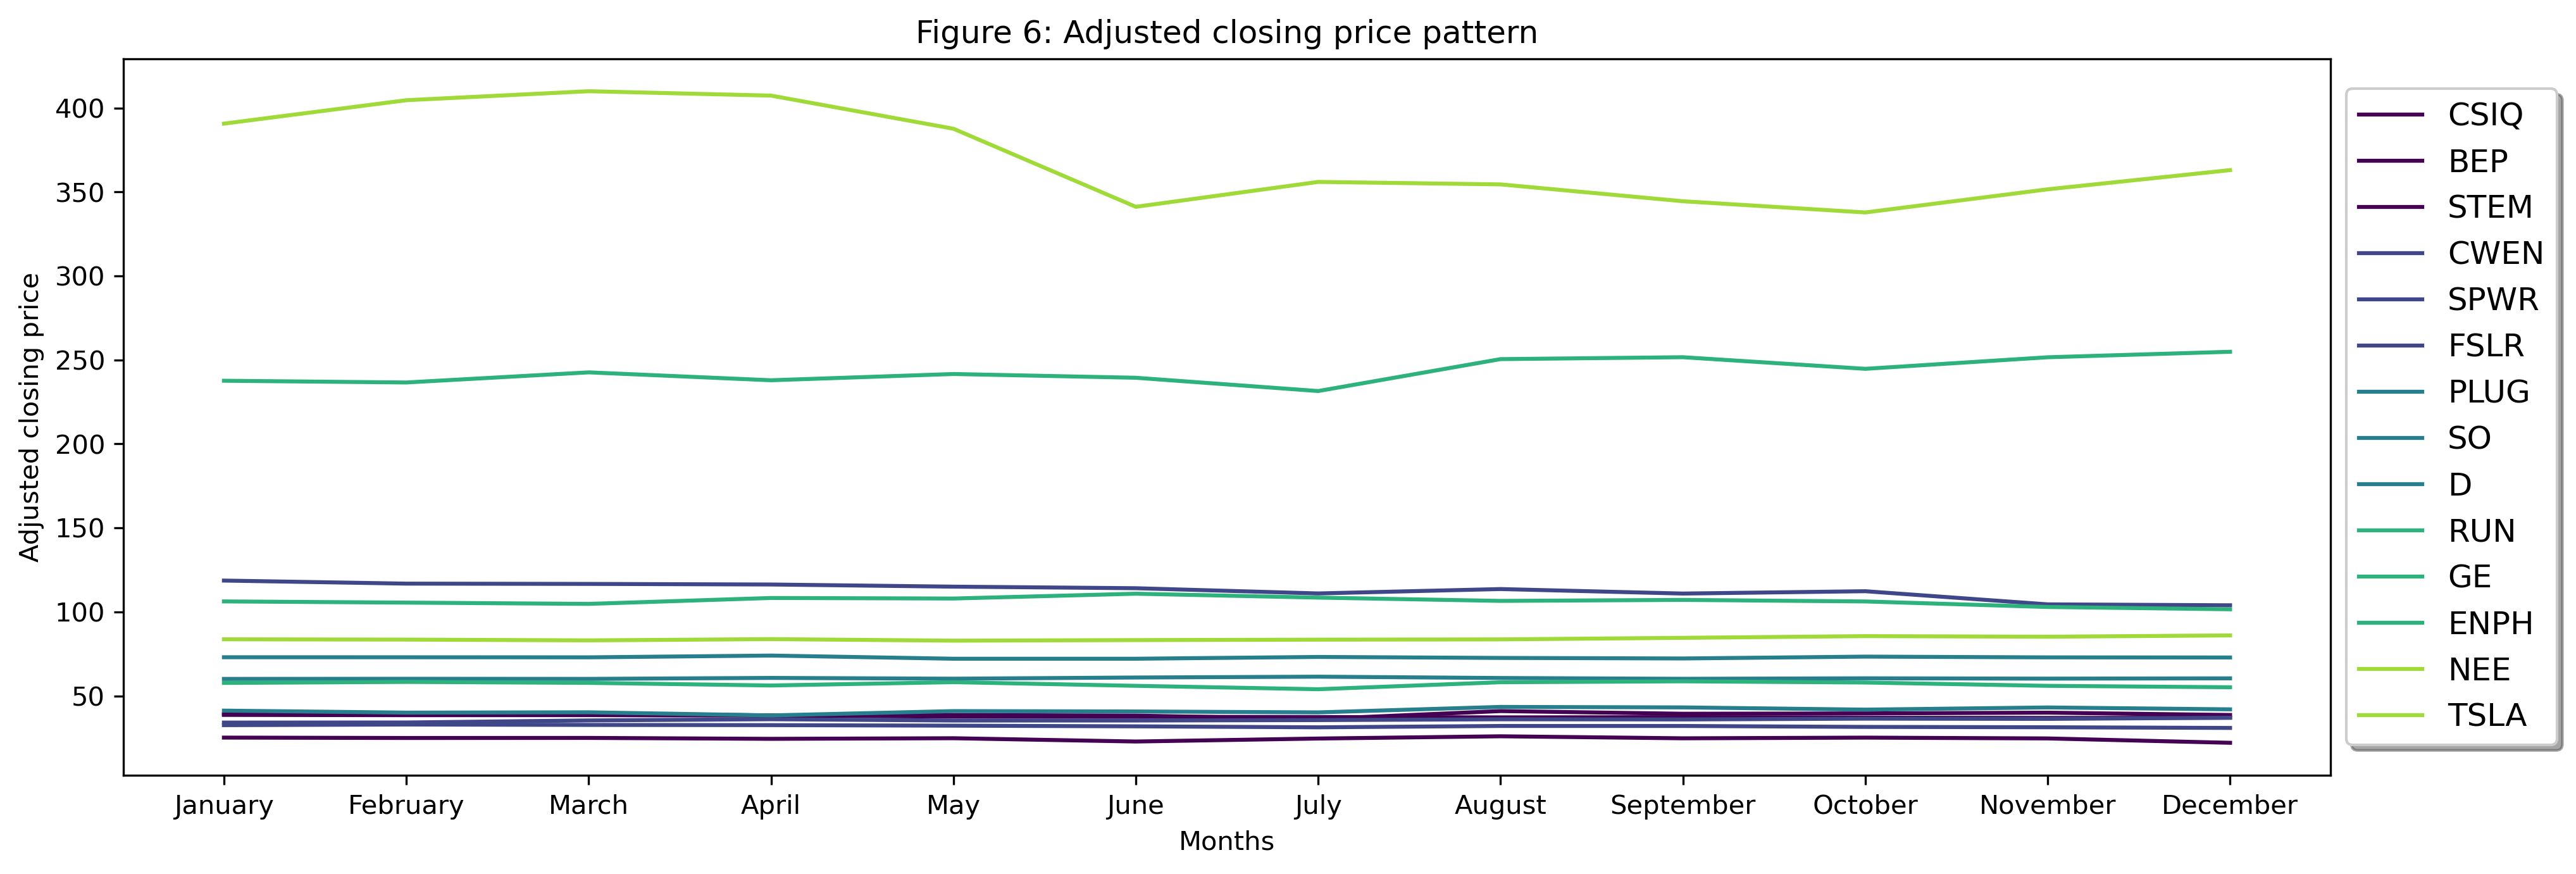

In [25]:
clean_energy_dataset = stock_data_processor.get_trends(clean_energy_stocks, period='monthly', category='adj_close', fig_no=6)

In [26]:
print(clean_energy_dataset.shape)
clean_energy_dataset.head(3)

(3528, 8)


Date       Open       High        Low      Close  Adj Close   Volume  \
0 2021-11-01  42.000000  43.139999  41.180000  41.290001  41.290001  1056100   
1 2021-11-02  40.689999  41.290001  39.000000  39.080002  39.080002  1125700   
2 2021-11-03  38.360001  39.549999  37.009998  39.529999  39.529999  1015400   

  company_name  
0         CSIQ  
1         CSIQ  
2         CSIQ

# 4. Exceptional Performance

In [27]:
clean_energy_stock_categorized = clean_energy_dataset.copy()
clean_energy_stock_data_sorted = clean_energy_stock_categorized.sort_values(by=['Date'])

In [28]:
clean_energy_stock_data_sorted.head(5)

Date        Open        High         Low       Close   Adj Close  \
0 2021-11-01   42.000000   43.139999   41.180000   41.290001   41.290001   
0 2021-11-01   24.000000   24.829000   23.820000   24.299999   24.299999   
0 2021-11-01   34.299999   34.610001   33.290001   33.849998   33.849998   
0 2021-11-01  120.250000  123.129997  117.870003  121.139999  121.139999   
0 2021-11-01   39.590000   41.900002   39.419998   41.650002   41.650002   

     Volume company_name  
0   1056100         CSIQ  
0   3051600         STEM  
0   3345400         SPWR  
0   2427000         FSLR  
0  44414400         PLUG

### 4.1 Evaluating clean energy stocks with associated high stock price pattern 

In [29]:
def condition1(df1,df2):
    bool_data = (df1-df2)>=0
    return bool_data

def condition2(df1,df2,cnt):
    transactions = df1['Date'].unique()
    companies = df1['company_name'].unique()
    temp_file_name = '../output/yfinance/prev_highest.pkl'
    if cnt==0:
        prev_highest_dict = {}
        for c in companies:
            prev_highest_dict[c]= df1['High'][df1['company_name']==c]
        with open(temp_file_name, 'wb') as f:
            pickle.dump(prev_highest_dict, f)
        cnt+=1
        bool_data = [b for b in df1['High']>0]
        return bool_data, cnt
    else:
        with open(temp_file_name, 'rb') as f:
            prev_highest_dict = pickle.load(f)
        bool_data=[]
        for c in companies:
            dic_prev = list(prev_highest_dict[c])
            prev = float(dic_prev[0])
            b = df1['High'][df1['company_name']==c]>prev
            bool_data.append(b)
        cnt+=1
        return bool_data, cnt

basket_df2 = stock_data_processor.get_transaction_basket(clean_energy_stock_data_sorted,
                                                           trans_col='Date',
                                                           basket_col='company_name', 
                                                           apply_condition= True,
                                                           condition_func=condition2,
                                                           condtn_colmn1=None, 
                                                           condtn_colmn2=None)

100%|█████████████████████████████████████████| 252/252 [00:02<00:00, 98.90it/s]


In [30]:
basket_df2.head(5)

trans_id                 Date  \
0        0  2021-11-01 00:00:00   
1        1  2021-11-02 00:00:00   
2        2  2021-11-03 00:00:00   
3        3  2021-11-04 00:00:00   
4        4  2021-11-05 00:00:00   

                                              basket  
0  [CSIQ, STEM, SPWR, FSLR, PLUG, SO, D, BEP, RUN...  
1                       [PLUG, SO, STEM, GE, NEE, D]  
2                                       [STEM, TSLA]  
3                           [ENPH, STEM, TSLA, CWEN]  
4                [CWEN, SO, STEM, GE, D, ENPH, TSLA]

In [31]:
freq_item3 = association_rule_mining.get_frequent_itemset(basket_df2['basket'], min_support=0.2, min_length=2, max_len=None)
energy_stock_top_20_frequency = freq_item3.sort_values('support',ascending=False).head(5).sort_values('support')
fig = px.bar(energy_stock_top_20_frequency, 
             x="support", 
             y="itemsets", 
             orientation='h',
             text='support',
             title="Figure 7: Clean energy stocks frequently associated high stock price")
fig.show();

In [32]:
clean_energy_top_comp_list = []
for item in energy_stock_top_20_frequency.itemsets:
    item_list = item.split(',')
    for item in item_list:
        clean_energy_top_comp_list.append(item.strip())
company_names, counts = np.unique(clean_energy_top_comp_list, return_counts=True)
count_sort_ind = np.argsort(-counts)
clean_energy_company_list = company_names[count_sort_ind]
print(clean_energy_company_list)

['SO' 'D' 'NEE' 'CWEN' 'ENPH']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


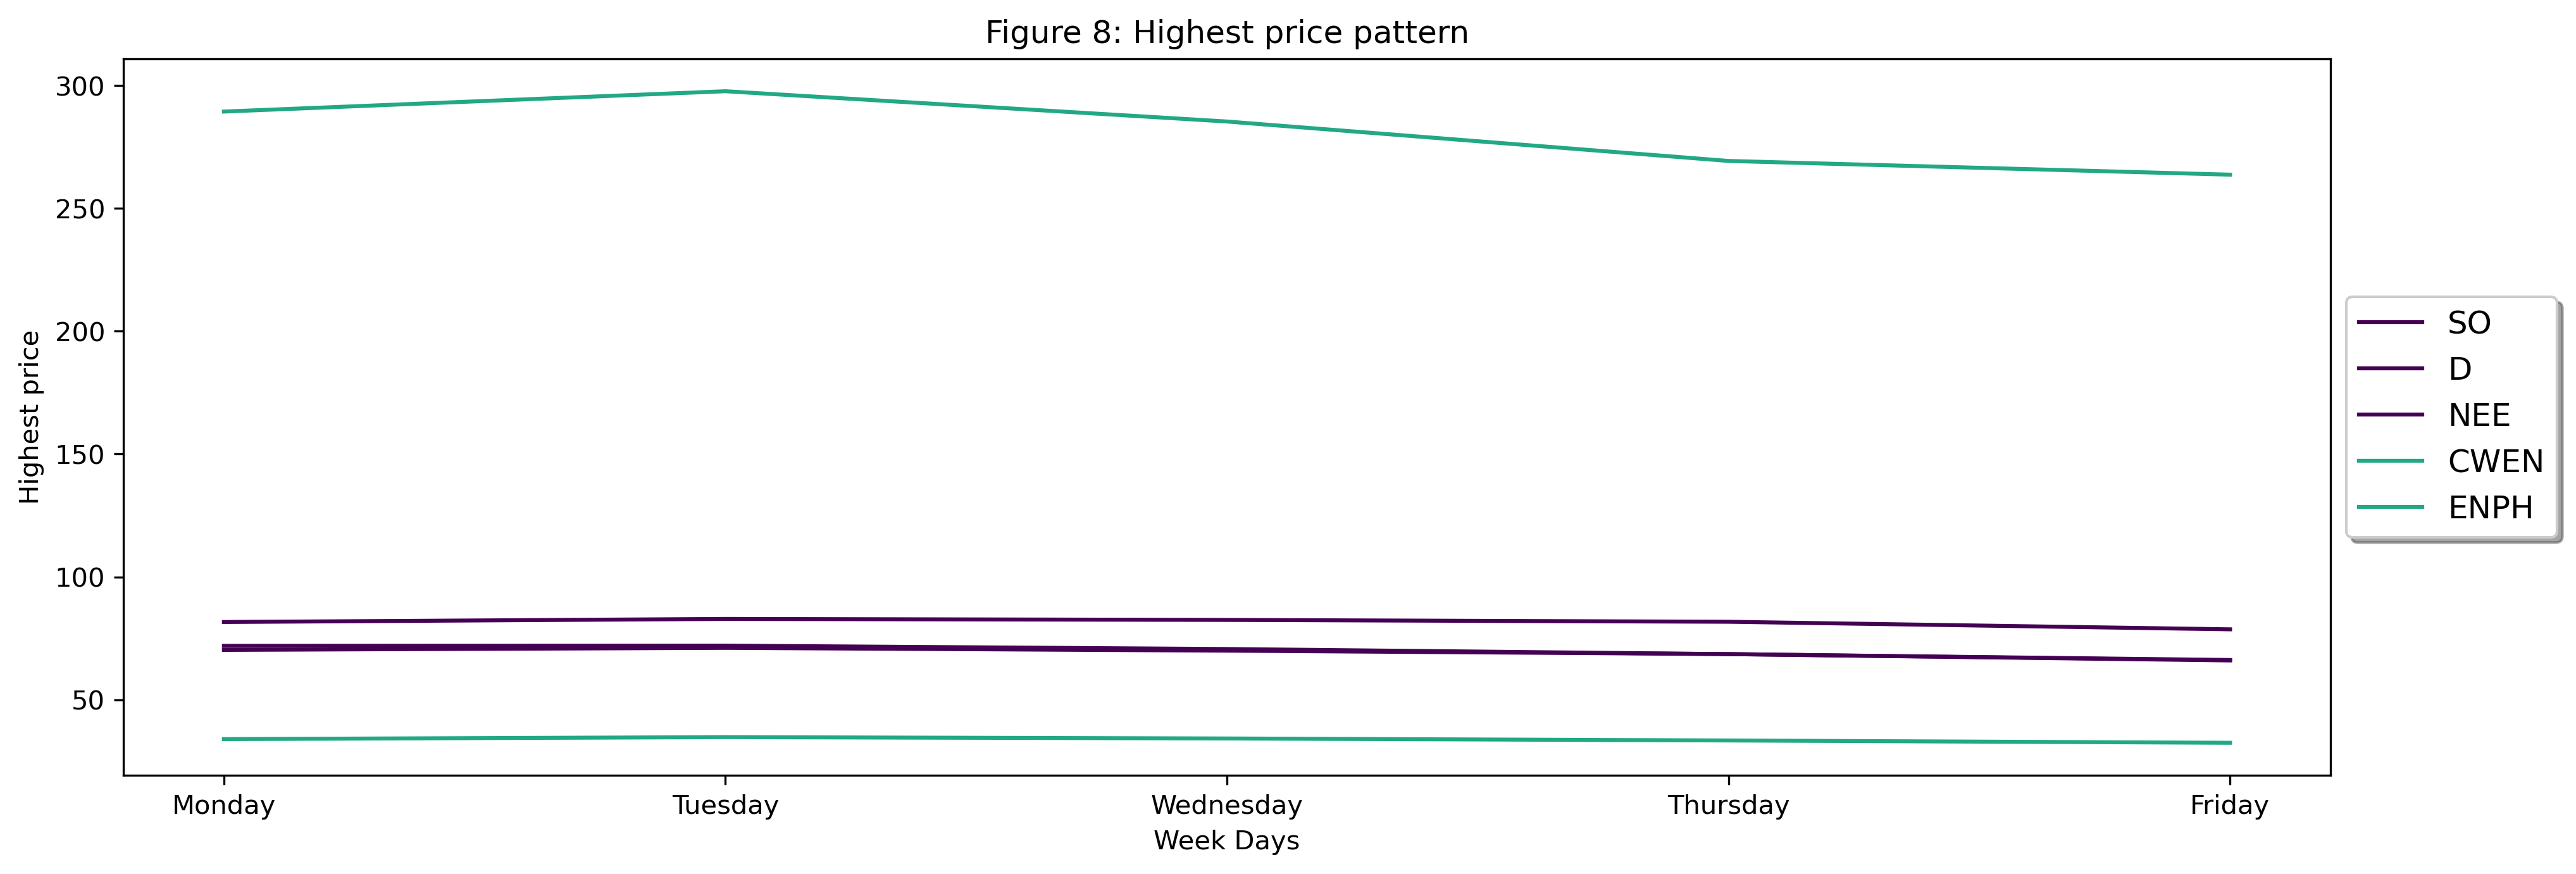

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


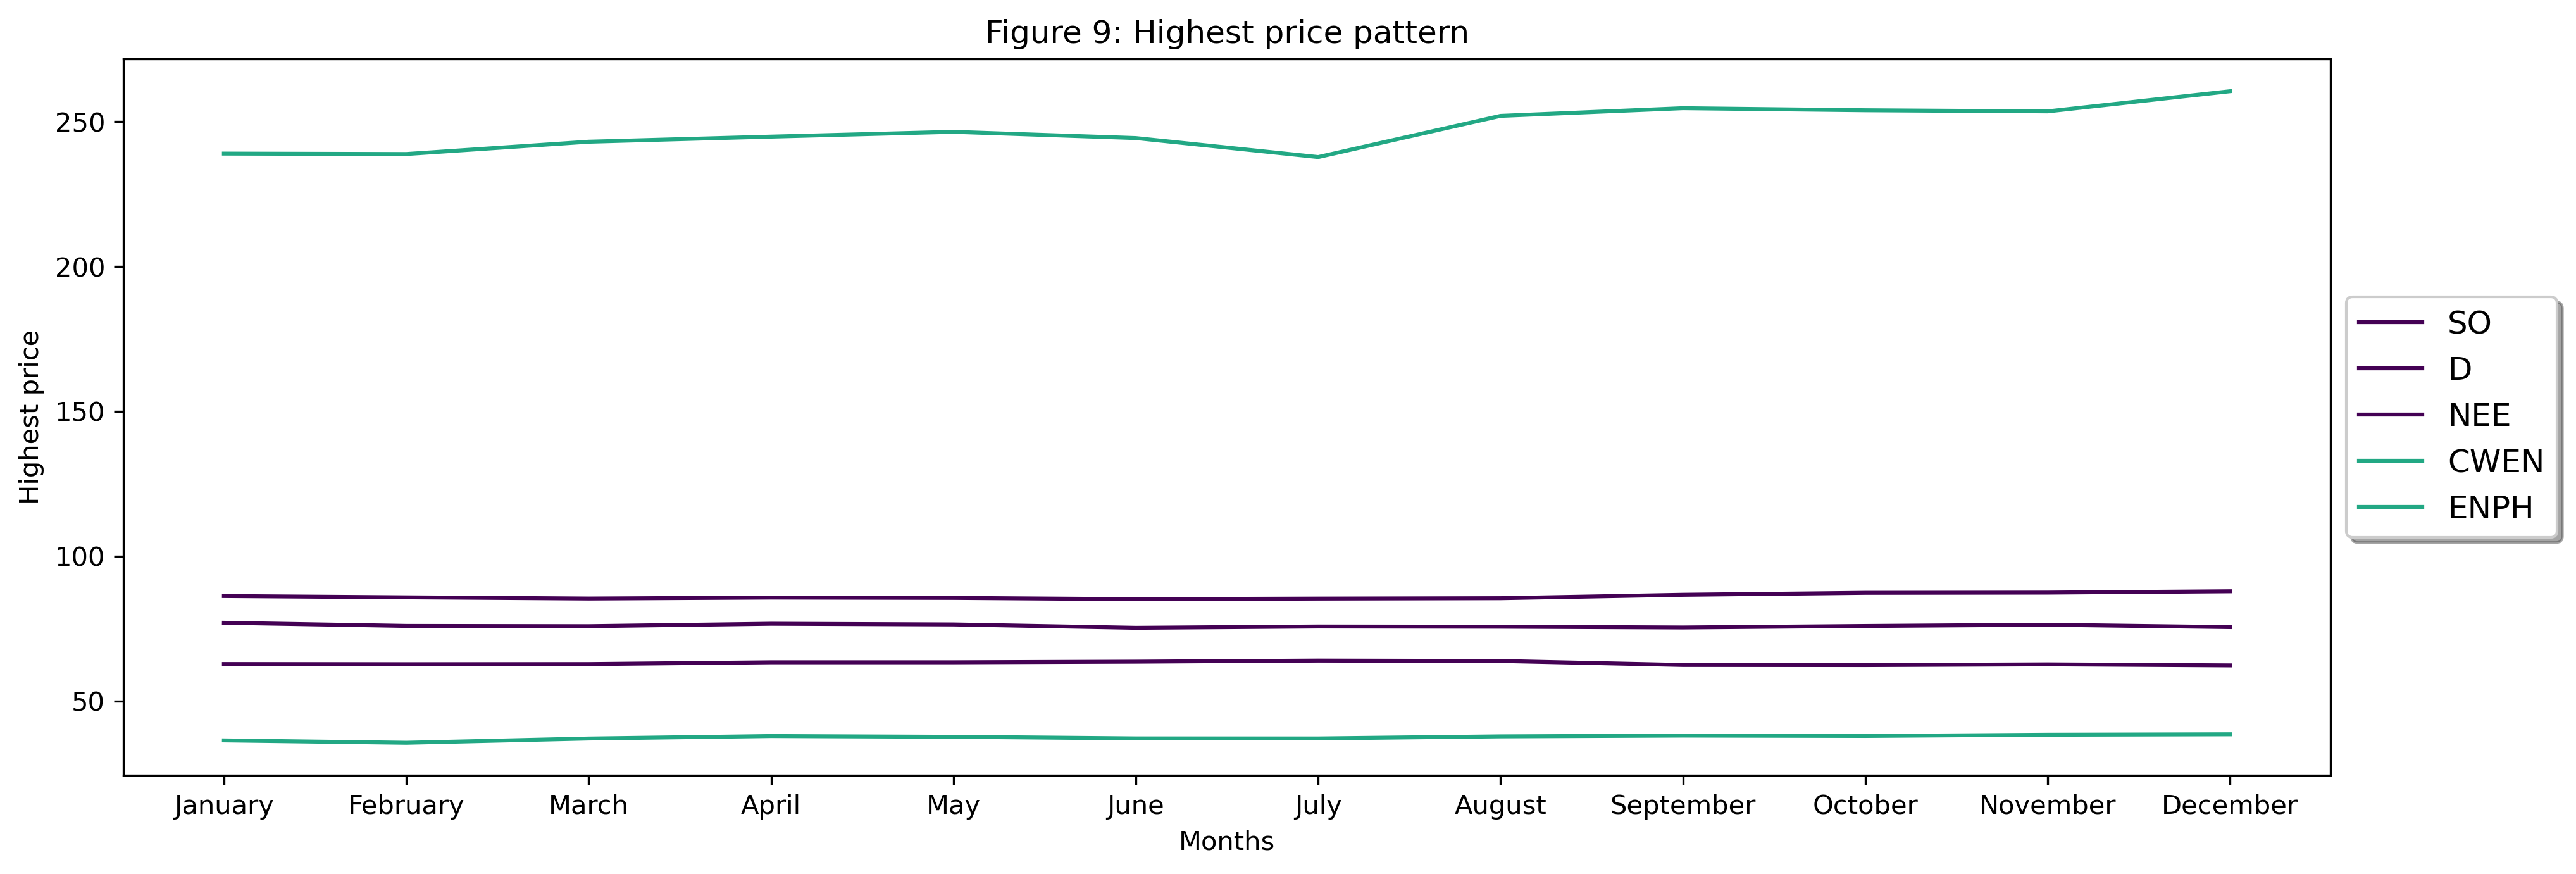

In [33]:
top_associated_clean_energy_comp = stock_data_processor.get_trends(clean_energy_company_list, period='weekly', category='highest_price', fig_no=8)
top_associated_clean_energy_comp = stock_data_processor.get_trends(clean_energy_company_list, period='monthly', category='highest_price', fig_no=9)

### 4.2 Evaluating prediction performance of regression model trained in section 2.2 on independent testset (14 clean energy dataset) 

In [34]:
X, Y  = predictor.get_data_for_model(clean_energy_stock_data_sorted, target_col='High')

In [35]:
Y_pred = best_model.predict(X)
r2 = r2_score(Y, Y_pred)
adj_r2 = predictor.adjusted_r2(r2,len(Y_prediction), x_train.shape[1])
print("Test result (Adjusted R2) on the whole dataset:", adj_r2)

Test result (Adjusted R2) on the whole dataset: 0.998251932928655


In [37]:
res = [val for key, val in enumerate(brazilian_stock_company_names) if val in set(clean_energy_stocks)]
print("# Number of clean energy stock trading on Brazilian stock market:", len(res))

# Number of clean energy stock trading on Brazilian stock market: 0


### 4.3 Analysis of the prediction model:
Interestingly we can see that the prediction model provided a 99% adjusted R2 score on a completely independent dataset consisting of 14 clean energy stocks. 